In [1]:
# !pip install nltk gdown seaborn torchtext pymorphy2 gensim

In [2]:
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Семинар: Language Model

Привет! Сегодня мы создадим свою Language Model! Посмотрим на три вида моделей: N-gram, CNN, LSTM. Для обучения LM лучше всего подходят большие корпуса с разнообразными текстами: от новостей до художственной литературы. Для русского языка есть большой корпус [Taiga](https://tatianashavrina.github.io/taiga_site/). Для английского используют тексты из [википедии](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) или [BookCorpus](https://github.com/soskek/bookcorpus). 

Сегодня вы возьмем маленькую часть датасета Taiga: новости с сайта [nplus1](https://nplus1.ru). Каждая новость на сайте помечается меткой сложности (от 0 до 10). Это не поможет нам с обучением хорошей LM, но даст возможность поиграться с генерацией текста.

Загрузим датасет и подготовим его к работе!

In [3]:
import gdown


gdown.download("https://drive.google.com/uc?id=1UtF9urwAL2OiMg7N5iFmZmeiRzq1Psw6")

Downloading...
From: https://drive.google.com/uc?id=1UtF9urwAL2OiMg7N5iFmZmeiRzq1Psw6
To: /home/adchumachenko/dls/lm/nplus1.zip
49.8MB [00:02, 17.4MB/s]


'nplus1.zip'

In [4]:
!unzip nplus1.zip

Archive:  nplus1.zip
replace nplus1/newmetadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [6]:
!ls nplus1/

newmetadata.csv  texts	texts_tagged


Вся информация про тексты содержится в таблице `newmetadata.csv`. Загрузим её с помощью `pandas`.

In [7]:
import pandas as pd


metadata = pd.read_table("nplus1/newmetadata.csv")
metadata.head()

,segment,textid,textname,textregion,textrubric,textdiff,author,authortexts,authorreaders,magazine,date,time,tags,source
0,nplus1,20151029radar,Французы испытали пассивный «летающий радар»,NaN,Оружие,2.1,Василий Сычев,NaN,NaN,NaN,29 Окт. 2015,16:47,NaN,https://nplus1.ru/news/2015/10/29/radar
1,nplus1,20161212aggressive-drones,Для агрессивных маневров дронам хватило камеры...,NaN,Технологии,2.6,Николай Воронцов,NaN,NaN,NaN,12 Дек. 2016,17:27,NaN,https://nplus1.ru/news/2016/12/12/aggressive-d...
2,nplus1,20150826twinjet-hubble,«Хаббл» получил новые фотографии «крыльев» Баб...,NaN,Технологии,1.1,NaN,NaN,NaN,NaN,26 Авг. 2015,17:46,NaN,https://nplus1.ru/news/2015/08/26/twinjet-hubble
3,nplus1,20150826shining-solved-profile,Криминологи научились вычислять будущих бытовы...,NaN,NaN,4.4,NaN,NaN,NaN,NaN,26 Авг. 2015,14:15,NaN,https://nplus1.ru/news/2015/08/26/shining-solv...
4,nplus1,20160111snow,Ford начал снежные испытания беспилотного авто...,NaN,Транспорт,1.7,Василий Сычев,NaN,NaN,NaN,11 Янв. 2016,09:44,NaN,https://nplus1.ru/news/2016/01/11/snow


Колонка `textdiff` содержит информацию про сложность текста. Чтобы выделить нужный кусок, воспользуемся методами `pandas`.

In [8]:
metadata[(metadata["textdiff"] > 4) & (metadata["textdiff"] < 5)].shape

(793, 14)

Посмотрим на распределение сложности текстов:

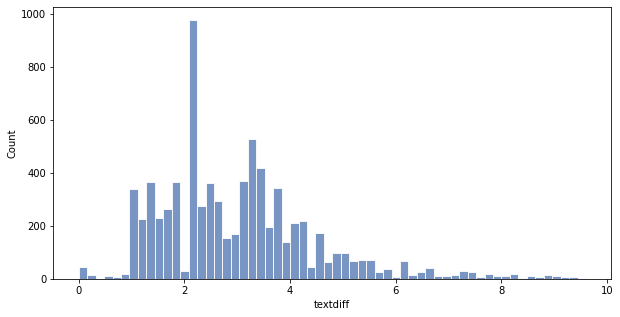

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


_, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.set()
sns.histplot(metadata["textdiff"], ax=ax)

Загрузим предобученные эмбеддинги, которые готовы к работе с русским языком ([весь список](https://rusvectores.org/ru/models/)). Из-за особенностей русского языка эмбеддинги ожидают строку вида `{слово}_{часть речи}`. Надо про это помнить при работе с этими эмбеддингами.

In [10]:
from gensim import downloader as api

word2vec = api.load('word2vec-ruscorpora-300')

Подготовим датасет к работе с моделями:

In [122]:
from pathlib import Path
import string

import numpy as np
from tqdm.notebook import tqdm

import nltk
from pymorphy2 import MorphAnalyzer

from torch.utils.data import Dataset, random_split


PAD = "<PAD>"
EOS = "<EOS>"
UNK = "<UNK>"


class TextDataset(Dataset):
    def __init__(self, min_diff=0, max_diff=10):
        self.root = Path("nplus1/texts")
        metadata = pd.read_table("nplus1/newmetadata.csv")
        self.metadata = metadata[(metadata["textdiff"] > min_diff) & (metadata["textdiff"] <= max_diff)]
        
        # Получим список всех текстов и сверим его с таблицей
        file_paths = np.array(list(self.root.glob("*.txt")))
        text_ids = np.array(list(path.name.split(".")[0] for path in file_paths))
        self.text_ids = text_ids[np.isin(text_ids, self.metadata["textid"])]
        self.file_paths = file_paths[np.isin(text_ids, self.metadata["textid"])]
        
        self.min_diff = min_diff
        self.max_diff = max_diff
        
        self.tokenizer = nltk.WordPunctTokenizer()
        self.morph = MorphAnalyzer()
        
        self.token2idx = {PAD: 0, EOS: 1, UNK: 2}
        self.vocab = set([PAD, EOS, UNK])
        for path in tqdm(self.file_paths):
            with open(path) as file:
                text = file.read()
                self.vocab.update([token for token in self.tokenize_(text) if token not in (UNK, PAD, EOS)]) # добавь токены в словарь
        self.token2idx.update({t:num + 3 for num, t in enumerate(self.vocab) if t not in (UNK, PAD, EOS)})
        self.idx2token = {num: token for token, num in self.token2idx.items()}
            
    
    def __getitem__(self, item):
        with open(self.file_paths[item]) as file:
            text = file.read()
            
        tokens = self.tokenize_(text)
        
        text_id = self.text_ids[item]
        textdiff = self.metadata[self.metadata["textid"] == text_id]["textdiff"]
        
        # для обучение нейронок нам потребуются индексы токенов в словаре.
        input_ids = [self.token2idx[token] for token in tokens]
        
        return {
            "text": text,
            "tokens": tokens,
            "textdiff": textdiff,
            "input_ids": input_ids
        }
    
    def __len__(self):
        return len(self.file_paths)
    
    def tokenize_(self, text):
        tokens = self.tokenizer.tokenize(text.lower())
        morphs = [self.morph.parse(token)[0]
                  for token in tokens 
                  if (token not in string.punctuation)]
        tokens = [f"{morph.normal_form}_{morph.tag.POS}" for morph in morphs]
        tokens = [token for token in tokens if token in word2vec]
        tokens += [EOS]
        return tokens
    
    def embeddins(self):
        w = torch.rand(len(self.vocab) + 1, word2vec.vector_size)
        for token, num in self.token2idx.items():
            if token in word2vec:
                w[num] = torch.from_numpy(word2vec[token])
        return w

In [123]:
dataset = TextDataset(0.5, 2)
train_size = np.ceil(len(dataset) * 0.8).astype(int)


train_dataset, valid_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

## 1. N-gram LM

Первая жертва – N-граммная модель. Она пишется скучно, но хорошо работает.

In [45]:
from collections import Counter, defaultdict

from tqdm.notebook import tqdm


class NGramModel(object):
    '''
    Структура этой реализации n-граммной модели следующая:
    self.ngrams – словарь, который на каждый (token_0, ..., token_(n-1)) – n-1 tuple из токенов
        хранит частоту появления следующего токена. Для подсчета числа токенов воспользуемся
        Counter
    self.tokenize_func – функция токенизации текста. С её помощью будем получать токены.
    '''
    def __init__(self, n=2):
        self.ngrams = defaultdict(Counter)
        self.n = n
        self.tokenize_func = None
        
    def compute_ngrams(self, dataset, tokenize_func):
        self.tokenize_func = tokenize_func
        self.ngrams = defaultdict(Counter)
        for row in tqdm(dataset):
            ngram = [PAD] * self.n
            for token in row["tokens"]:
                ngram[:-1] = ngram[1:]
                ngram[-1] = token
                self.ngrams[tuple(ngram[:-1])].update([ngram[-1]])
            
    def get_log_probs(self, prefix, min_log_pr=-15):
        '''
        Функция, которая будет возвращать логарифмы частот появления токенов
        '''
        if isinstance(prefix, str):
            # преврати строку в tuple из токенов с помощью tokenize_func. 
            prefix = self.tokenize_func(prefix)[:-1]
        if len(prefix) < self.n - 1:
            prefix = [PAD] * (self.n - len(prefix) - 1) + prefix
        else:
            prefix = prefix[-self.n + 1:]
        possible_ends = self.ngrams[tuple(prefix)]
        sum_freq = np.log(sum(possible_ends[e] for e in possible_ends))
        return {e: np.log(possible_ends[e]) - sum_freq for e in possible_ends}
    
    def sample(self, prefix):
        possible_ends = self.get_log_probs(prefix)
        if len(possible_ends) > 0:
            end = np.random.choice(list(possible_ends.keys()), p=np.exp(list(possible_ends.values())))
            return end
        return EOS

Создадим 5-граммную модель и посмотрим, как хорошо справляется она с генерацией текста.

In [46]:
frigram = NGramModel(5)

In [47]:
frigram.compute_ngrams(train_dataset, dataset.tokenize_)

In [48]:
frigram.get_log_probs("")

{'программист_NOUN': -4.899873009733009,
 'завод_NOUN': -5.68833037009728,
 'автомобиль_NOUN': -5.68833037009728,
 'управление_NOUN': -4.302036008977389,
 'главное_NOUN': -6.19915599386327,
 'центр_NOUN': -4.812861632743379,
 'ввс_NOUN': -5.218326740851545,
 'компания_NOUN': -1.5906580177825047,
 'организация_NOUN': -5.351858133476067,
 'армения_NOUN': -7.29776828253138,
 'зоолог_NOUN': -5.911473921411489,
 'орбита_NOUN': -7.29776828253138,
 'археолог_NOUN': -3.4059479844207536,
 'помощник_NOUN': -6.604621101971435,
 'конференция_NOUN': -6.604621101971435,
 'сша_NOUN': -5.68833037009728,
 'технология_NOUN': -7.29776828253138,
 'павел_NOUN': -7.29776828253138,
 'министерство_NOUN': -4.658710952916122,
 'исследователь_NOUN': -3.3465245639499526,
 'великобритания_NOUN': -6.604621101971435,
 'коллектив_NOUN': -7.29776828253138,
 'проведение_NOUN': -7.29776828253138,
 'время_NOUN': -4.995183189537334,
 'программа_NOUN': -6.19915599386327,
 'специалист_NOUN': -3.9655637723561763,
 'холдинг_N

In [50]:
frigram.sample("университет")

'шеффилд_NOUN'

In [51]:
def generate_text(model, prefix, length=100):
    text = "" + prefix
    while len(text) < length:
        token = model.sample(text)
        text += " " + token
        if token < EOS:
            break
    return text

In [52]:
generate_text(frigram, "")

' британия_NOUN фотограф_NOUN компания_NOUN компания_NOUN компания_NOUN станция_NOUN реставратор_NOUN'

Количественная величина, которая позволяет сравнивать LM: перплекция. Для её вычисления используется следующая формула:

$$
\text{Ppr} = \exp^{\frac{1}{|D|} \sum_{t \in D}\sum_{w \in t} - \log (p(w))},
$$
где $D$ – валидационный датасет, $|D|$ – общая длина текстов.

In [55]:
def perplexity_ngram(dataset, model):
    lengths = 0
    log_prob = 0
    for row in tqdm(dataset):
        tokens = row["tokens"]
        lengths += len(tokens)
        ngram = [PAD] * model.n
        for token in tokens:
            ngram[:-1] = ngram[1:]
            ngram[-1] = token
            log_prob += model.get_log_probs(ngram[:-1]).get(ngram[-1], -15)
    return np.exp(-log_prob / lengths)

In [56]:
perplexity_ngram(valid_dataset, frigram)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


1759708.2315360727

## 2. NN LM

Приступим к нейросетевым языковым моделям. Для начала нам потребуется сэмплер из прошлого семинара.

In [57]:
from torch.utils.data import Sampler


class TextSampler(Sampler):
    def __init__(self, sampler, batch_size_tokens=1e4):
        self.sampler = sampler
        self.batch_size_tokens = batch_size_tokens

    def __iter__(self):
        batch = []
        max_len = 0
        for ix in self.sampler:
            row = self.sampler.data_source[ix]
            max_len = max(max_len, len(row["input_ids"]))
            if (len(batch) + 1) * max_len > self.batch_size_tokens:
                yield batch
                batch = []
                max_len = len(row["input_ids"])
            batch.append(ix)
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.sampler)

In [58]:
def collate_fn(batch):
    max_len = max(len(row["input_ids"]) for row in batch)
    input_embeds = np.zeros((len(batch), max_len))
    for idx, row in enumerate(batch):
        input_embeds[idx][:len(row["input_ids"])] += row["input_ids"]
    row["input_ids"] = torch.LongTensor(input_embeds)
    return row

In [124]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, random_split


train_sampler = RandomSampler(train_dataset)
valid_sampler = SequentialSampler(valid_dataset)

train_loader = DataLoader(train_dataset, batch_sampler=TextSampler(train_sampler), collate_fn=collate_fn, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_sampler=TextSampler(valid_sampler), collate_fn=collate_fn, num_workers=4)

### CNN

Вторая жертва – CNN. Если внимательно посмотреть, то она является нейросетевым приближением к n-грамной модели. Для её реализации нам потребуется новым модуль – `nn.ZeroPad2d`[docs](https://pytorch.org/docs/stable/generated/torch.nn.ZeroPad2d.html). Он добавит нулей в нужном месте, чтобы конволюционный слой смотрел только на предыдущие токены при предсказании текущего.

In [125]:
import torch
import torch.nn as nn


class CNNLM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.pad = nn.ZeroPad2d((4, 0, 0, 0))
        self.conv = nn.Conv1d(emb_size, hidden_size, kernel_size=5)
        self.pred = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_ids):
        embed = self.emb(input_ids).permute(0, 2, 1)
        padded = self.pad(embed)
        convolved = torch.relu(self.conv(padded)).permute(0, 2, 1)
        return self.pred(convolved)

In [126]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

model = CNNLM(len(dataset.vocab) + 4, 300, 100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.token2idx[PAD])

In [127]:
def embeddings(self):
    w = torch.rand(len(self.vocab) + 4, word2vec.vector_size)
    for token, num in self.token2idx.items():
        if token in word2vec:
            w[num] = torch.from_numpy(word2vec[token])
    return w

In [128]:
with torch.no_grad():
    model.emb.weight.copy_(embeddings(dataset))

In [129]:
num_epochs = 1

for e in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader)) as pbar:
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)

            prediction = model(input_ids[:, :-1])
            loss = criterion(
                prediction.reshape(-1, prediction.size(-1)), 
                input_ids[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            # обучи модель 

            pbar.update(input_ids.size(0))
        
    model.eval()
    valid_loss = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_loader:
            n_iter += 1
            input_ids = batch["input_ids"].to(device)
            prediction = model(input_ids[:, :-1])
            valid_loss += criterion(prediction.reshape(-1, prediction.size(-1)), input_ids[:, 1:].reshape(-1))
    print(f"Valid Loss: {valid_loss / n_iter}, Valid Peprplexity: {torch.exp(valid_loss / n_iter)}")


Valid Loss: 7.620480060577393, Valid Peprplexity: 2039.5408935546875


После обучения модели посмотрим, как она справляется с задачей генерации текста. Сделаем специальную функцию для этого.

In [130]:
def sample(model, prefix, max_length=100):
    tokens = dataset.tokenize_(prefix)[:-1]
    input_ids = [dataset.token2idx.get(token) for token in tokens]
    input_ids_tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)
    
    with torch.no_grad():
        while True:
            output = model(input_ids_tensor)

            probs = torch.softmax(output[:, -1].cpu(), -1).numpy()[0]
            # получи из output вероятности следующего токена
            next_id = np.random.choice(np.arange(len(dataset.vocab) + 4), p=probs)
            # получи следующий токен
            tokens += [dataset.idx2token[next_id]]
            # добавь токен в список токенов
            
            if dataset.idx2token[next_id] == EOS or len(tokens) > max_length:
                break
            input_ids += [next_id]
            input_ids_tensor = torch.LongTensor(input_ids).unsqueeze(0).to(device)
    
    return " ".join(t.split("_")[0] for t in tokens)

In [131]:
model.eval()
sample(model, "университет")

'университет пойти сочетание перстень местность шик хоббит подвергать штопор запись превышать камера дорога вилма сохранять мочь предел соединение тим окситоцин подскакивать сканирование вода мир глава тысяча лето ответ <EOS>'

### LSTM

Последняя жертва – LSTM. Она должна лучше работать с длинными текстами, потому что у неё нет фиксированного количества токенов, на которые она можеть "смотреть".

In [132]:
import torch
import torch.nn as nn


class LSTMLM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(vocab_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        # Сделай lstm слой
        self.pred = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_ids):
        embs = self.emb(input_ids)
        output, _ = self.lstm(embs)
        return self.pred(output)

In [133]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"

model = LSTMLM(len(dataset.vocab) + 4, 300, 100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.token2idx[PAD])

In [134]:
with torch.no_grad():
    model.emb.weight.copy_(embeddings(dataset))

In [135]:
num_epochs = 1

for e in range(num_epochs):
    model.train()
    with tqdm(total=len(train_loader)) as pbar:
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)

            prediction = model(input_ids[:, :-1])
            loss = criterion(
                prediction.reshape(-1, prediction.size(-1)), 
                input_ids[:, 1:].reshape(-1))
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            # обучи модель 

            pbar.update(input_ids.size(0))
        
    model.eval()
    valid_loss = 0
    n_iter = 0
    with torch.no_grad():
        for batch in valid_loader:
            n_iter += 1
            input_ids = batch["input_ids"].to(device)
            prediction = model(input_ids[:, :-1])
            valid_loss += criterion(prediction.reshape(-1, prediction.size(-1)), input_ids[:, 1:].reshape(-1))
    print(f"Valid Loss: {valid_loss / n_iter}, Valid Peprplexity: {torch.exp(valid_loss / n_iter)}")


Valid Loss: 7.757643699645996, Valid Peprplexity: 2339.385986328125


In [137]:
model.eval()
sample(model, "университет")

'университет сопровождаться динамика выстреливаться получить роскосмос время комета доллар астероид покров взаимодействие компания экран обитать штукатурка игра мкс проект элемент обеспечивать творение наведение фигурка услышать донор соя движение воронцов <EOS>'

### Что дальше?
 
Если мы говорим про генерацию, то модель надо обучать подольше и на большом количестве текста. Если хочешь поэкспериментировать с генерацией, то я предлагаю такой план:
 
- обучи модель на всех новостях (min_diff=0, max_diff=10)
- сохрани веса этой модели (torch.save(model.state_dict()))
- переобучи несколько моделей на новостях с другими значениями сложности (eg. (min_diff=1, max_diff=3), (min_diff=4, max_diff=8))
- сравни сгенерированные тексты

charLM
CNN(char) -> LSTM
BPE